In [1]:
import os
import torch
import torch.optim
import numpy as np
import pandas as pd
from PIL import Image
import torchvision.models as models
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
categories = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel',
          'Red Mullet', 'Red Sea Bream', 'Sea Bass',
          'Shrimp', 'Striped Red Mullet', 'Trout']

In [4]:
PATH = '/content/drive/Shareddrives/COMP576/dataset/Images'
CSV_PATH = "/content/drive/Shareddrives/COMP576/code/test_data_aug.csv"
MODEL_PATH = "/content/drive/Shareddrives/COMP576/code/model_weights_aug.pth"

In [5]:
data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [6]:
data = pd.read_csv(CSV_PATH)

# Load the weights

In [7]:
device = torch.device('cuda')
model = models.resnet18()
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, 9)

In [8]:
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

# Define prediction function

In [9]:
from scipy.special import softmax

def predict(model, test_terns):
    model.eval()   
    predictLabel = []

    with torch.no_grad():
    # Iterate over data.
        outputs = model(test_terns).detach().cpu().numpy()
        prob = softmax(outputs, axis=1)
        prob = np.max(prob, axis=1)

        preds = outputs.argmax(axis=1)
        predictLabel.extend(preds)

    return prob, np.array(predictLabel)

In [10]:
batch = 500
num_of_batch = int(data.shape[0]//batch) + 1
num_of_batch

5

In [12]:
labelsPred = []
probs = []
for _ in range(num_of_batch):
    test_terns = []
    for i in range(batch):
        idx = _ * batch + i
        if idx == data.shape[0]:
            break
        img_name = os.path.join(PATH, data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        image = data_transforms(image)
        test_terns.append(image)

    test_fish = torch.stack(test_terns)
    outputs, preds = (predict(model, test_fish))
    for pred, prob in zip(preds, outputs):
        probs.append(prob)
        labelsPred.append(categories[pred])

In [13]:
data["prob"] = probs
data["predictLabel"] = labelsPred

In [14]:
falsePred = data[data['trueLabel']!=data['predictLabel']]
truePred = data[data['trueLabel']==data['predictLabel']]

In [16]:
print(len(falsePred))
print(len(truePred))
print(len(data))

11
2330
2341


In [17]:
print("Accuracy in test dataset is: ", 1-(len(falsePred) / len(data)))

Accuracy in test dataset is:  0.9953011533532679


# Confusion Matrix

In [18]:
import matplotlib.pyplot as plt

In [19]:
df_confusion = pd.crosstab(data['trueLabel'], data['predictLabel'])

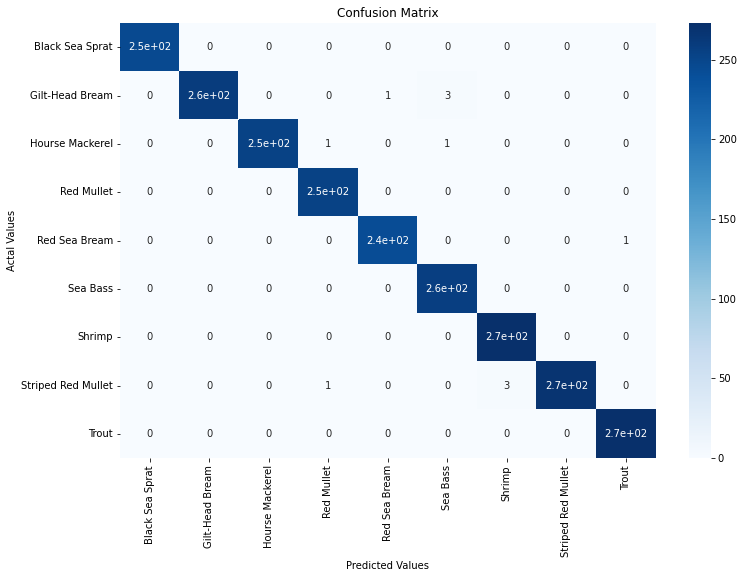

In [20]:
import seaborn as sns
df_confusion
plt.figure(figsize=(12,8))
sns.heatmap(df_confusion, annot=True, cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# Grad Cam

In [21]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-l3m656j6
  Running command git clone -q https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-l3m656j6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=37443 sha256=be468f87f1377294351fd228e9a45c69980d8bb388a87b7896ad2fb2c3eada64
  Stored in directory: /tmp/pip-ephem-wheel-cache-uff0bf04/wheels/08/90/37/328e561bf446935c29c8001960101bc47c8433bfebd3f42fd5
Successfully built grad-cam


In [22]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [23]:
target_layers = [model.layer4[-1]]

In [24]:
columns = 4*2
rows = 5

In [25]:
def gradCam(specie, NoiseImg = False):
  filenames = truePred[truePred['trueLabel']==specie].sort_values("prob", ascending=False)['filename'].values[:rows*columns//2]
  
  fig = plt.figure(figsize=(16, 12))
  with EigenGradCAM(model=model, target_layers=target_layers, use_cuda=False) as cam:
      for i in range(1, columns*rows+1, 2):
        if bool(NoiseImg) ^ bool('Addnoise' not in filenames[i//2]) :
          path = PATH + "/" + filenames[i//2]
          rgb_img = Image.open(path).convert('RGB')

          img_aft_transform = data_transforms(rgb_img)
          input_tensor = img_aft_transform.unsqueeze(0).float()
          rgb_img_normalize = (img_aft_transform).cpu().detach().numpy()
          rgb_img_normalize = (rgb_img_normalize - np.min(rgb_img_normalize)) / (np.max(rgb_img_normalize) - np.min(rgb_img_normalize))
          rgb_img_normalize = rgb_img_normalize.transpose(1, 2, 0)

          grayscale_cam = cam(input_tensor=input_tensor)

          grayscale_cam = grayscale_cam[0, :]
          visualization = show_cam_on_image(rgb_img_normalize,
                            grayscale_cam, 
                            use_rgb=True)
          cam_img = Image.fromarray(visualization, 'RGB')

          cam_img = cam_img.resize(size=rgb_img.size)
          origin_img = Image.open(path).convert('RGB')

          fig.add_subplot(rows, columns, i)
          plt.imshow(cam_img)
          fig.add_subplot(rows, columns, i+1)
          plt.imshow(origin_img)
  plt.show()
  return fig

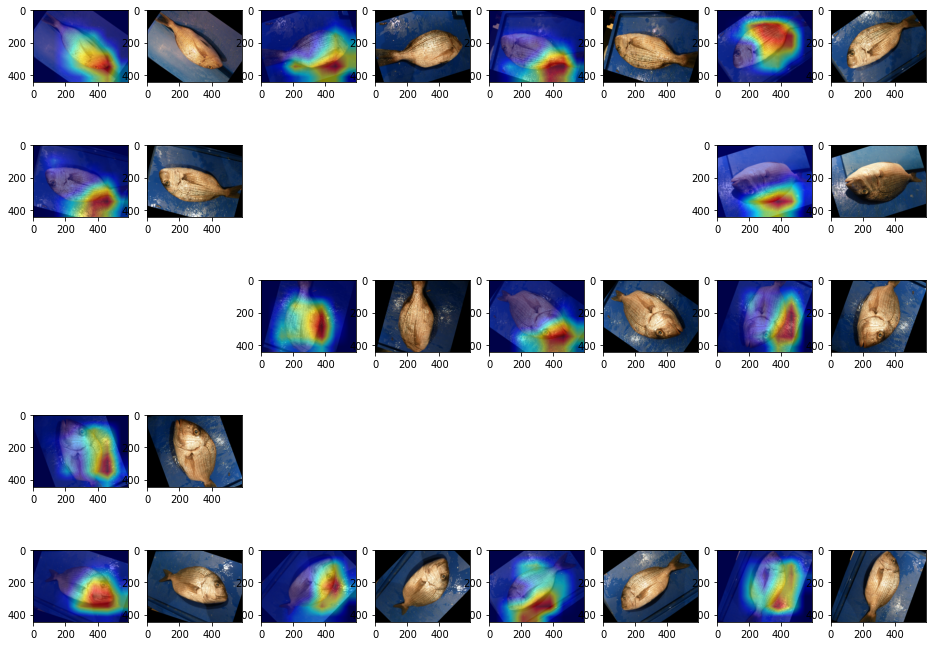

In [26]:
f = gradCam("Red Sea Bream")

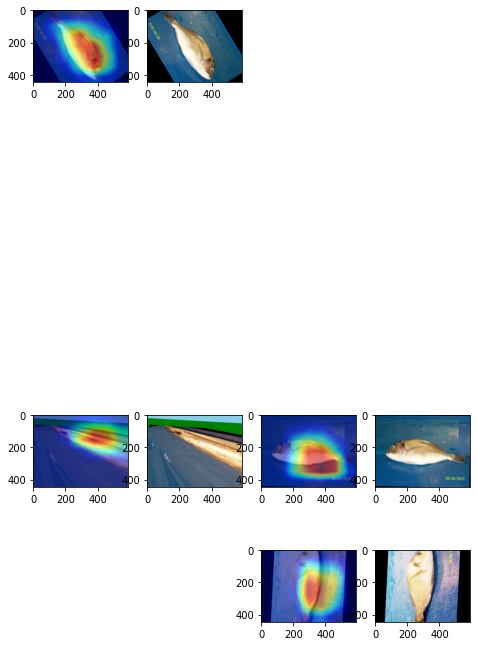

In [27]:
f = gradCam("Gilt-Head Bream")